In [93]:
from langgraph.graph import StateGraph,START,END,MessagesState
from azure.identity import DefaultAzureCredential, get_bearer_token_provider
from langchain_openai import AzureChatOpenAI
from langchain_core.tools import tool


from langgraph.checkpoint.memory import InMemorySaver
from langchain_core.messages import AIMessage,HumanMessage,trim_messages
from langchain_community.utilities import OpenWeatherMapAPIWrapper
from langgraph.prebuilt import ToolNode,tools_condition
from langchain_community.agent_toolkits.amadeus.toolkit import AmadeusToolkit


from IPython.display import display,Image
from dotenv import load_dotenv
import os



In [81]:
load_dotenv()
openweatherapikey = os.getenv("OPENWEATHERMAP_API_KEY")
token_provider= get_bearer_token_provider(DefaultAzureCredential(),"https://cognitiveservices.azure.com/.default")
chatmodel = AzureChatOpenAI(
    api_version="2024-12-01-preview",
    azure_endpoint="https://azopenai-langchain.openai.azure.com/",
    azure_ad_token_provider= token_provider,
    model= "gpt-4o-mini"
)

In [95]:
toolkit = AmadeusToolkit()
tools = toolkit.get_tools()

PydanticUserError: `AmadeusToolkit` is not fully defined; you should define `Client`, then call `AmadeusToolkit.model_rebuild()`.

For further information visit https://errors.pydantic.dev/2.11/u/class-not-fully-defined

In [ ]:
@tool
def get_activities_and_attractions(place : str) -> str:
    """ 
    This tool will help to get the activities and attractions for a given city.
    
    Input:
      place (str)

    Output:
     attractions and activities (str)    
    """
    

PydanticUserError: `AmadeusToolkit` is not fully defined; you should define `Client`, then call `AmadeusToolkit.model_rebuild()`.

For further information visit https://errors.pydantic.dev/2.11/u/class-not-fully-defined

In [83]:
@tool
def get_forecast_weather(place : str) -> MessagesState:
    """ 
    This tool will help to get the forecasted weather for a given city.
    
    Input:
      place (str)

    Output:
     forecasted weather (str)    
    """
    weather = OpenWeatherMapAPIWrapper(openweathermap_api_key= openweatherapikey)
    weather_data = weather.run(place)
    return weather_data

In [84]:
weather = OpenWeatherMapAPIWrapper(openweathermap_api_key= openweatherapikey)
weather_data = weather.run("Delhi")
weather_data

'In Delhi, the current weather is as follows:\nDetailed status: overcast clouds\nWind speed: 3.11 m/s, direction: 109°\nHumidity: 57%\nTemperature: \n  - Current: 35.99°C\n  - High: 35.99°C\n  - Low: 35.99°C\n  - Feels like: 42.99°C\nRain: {}\nHeat index: None\nCloud cover: 94%'

In [85]:
def call_llm(state:MessagesState)-> MessagesState:
     tools= [get_activities_and_attractions,get_forecast_weather]
     chatmodel_with_tools = chatmodel.bind_tools(tools)
     state["messages"] = chatmodel_with_tools.invoke(state["messages"])
     return state

In [79]:
tools= [get_activities_and_attractions,get_forecast_weather]
chatmodel_with_tools = chatmodel.bind_tools(tools)
chatmodel_with_tools.invoke("Is it going to rain tomorrow in Pune?").pretty_print()

================================== Ai Message ==================================
Tool Calls:
  get_forecast_weather (call_bKtDa0QheSVykBT2MWQ8Le2R)
 Call ID: call_bKtDa0QheSVykBT2MWQ8Le2R
  Args:
    place: Pune


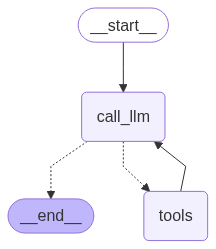

In [86]:


graph = StateGraph(MessagesState)

graph.add_node("call_llm",call_llm)
graph.add_node("tools",ToolNode(tools=tools))
graph.add_edge(START,"call_llm")
graph.add_conditional_edges("call_llm",tools_condition)
graph.add_edge("tools","call_llm")
compiledgraph = graph.compile()

display(Image(compiledgraph.get_graph().draw_mermaid_png()))

In [92]:
response = compiledgraph.invoke({"messages" : "Is it going to rain tomorrow in newyork?"})
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

Is it going to rain tomorrow in newyork?
================================== Ai Message ==================================
Tool Calls:
  get_forecast_weather (call_92HKbjXJjyGmhBzmPjgamZc7)
 Call ID: call_92HKbjXJjyGmhBzmPjgamZc7
  Args:
    place: newyork
================================= Tool Message =================================
Name: get_forecast_weather

Error: NotFoundError('Unable to find the resource')
 Please fix your mistakes.
================================== Ai Message ==================================
Tool Calls:
  get_forecast_weather (call_JFtwPyrSVdLxup0GZjsSdG2z)
 Call ID: call_JFtwPyrSVdLxup0GZjsSdG2z
  Args:
    place: New York
================================= Tool Message =================================
Name: get_forecast_weather

In New York, the current weather is as follows:
Detailed status: overcast clouds
Wind speed: 2.77 m/s, direction: 81°
Humidity: 86%
Temperature: 
  -